### Compare the water surface elevation (wse) generated from xbeach and the one from the lab data

Author: WaveHello
Date: 08/01/24

In [1]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import math
from scipy.interpolate import interp1d

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [2]:
from xbTools.xbeachpost import XBeachModelAnalysis


In [3]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run

In [4]:
# Functions 
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def find_closest(array, target):
    # Convert array to a NumPy array if it is not already
    array = np.array(array)
    
    # Compute the absolute differences between each element and the target
    diff = np.abs(array - target)
    
    # Find the index of the minimum difference
    idx = diff.argmin()
    
    # Get the value at that index
    closest_value = array[idx]
    
    return closest_value, idx

def calc_RMSE(observed_vals: np.array, predicted_vals: np.array) -> np.float64:
    """
    Calc the Root Mean squared error for a discrete set of data
    """

    # Check that the observed and the predicted are the same length
    if observed_vals.shape == predicted_vals.shape:
        # Choose one of the arrays since their equal and get the total number of values
        num_vals = observed_vals.size
    else:
        # if the shapes aren't the 
        raise IndexError(f"\nThe shape of observed vals is: {np.shape(observed_vals)}\n"
                         f"The shape of predicted vals is: {np.shape(predicted_vals)}\n")
    
    # Calc the sqaured difference between each term
    abs_diff = (observed_vals - predicted_vals)**2
    
    # Calc the term inside of the square root
    inside   = np.sum(abs_diff) / num_vals 

    # Return the RMSE
    return np.sqrt(inside)

In [5]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"..\..\..\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "020"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the wave data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

# Print info
print(f"Run{run_number} wave mat file path: {wave_data_path}")


Run020 wave mat file path: ..\..\..\BarSed_Data\WG\RUN020.mat


In [6]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = None)

print(Run_data)


id: RUN020
Start Date: None
Wave Data File path: ..\..\..\BarSed_Data\WG\RUN020.mat
Num pressure gagues: None
Num advs: None


In [7]:
Run_data.load_wave_data()

New Number of 17 wave gauges


In [8]:
# Construct the wse elevation as mesured by the wave gauges 
# (doesn't include wave maker)
Run_data.construct_wave_gauge_wse()

# Make an array of all the wave gauge locations
Run_data.get_wave_gauge_locations()

# Construct the elevation of the flume as measured by the wave gauges and 
# the wave maker
Run_data.construct_flume_wse()

# Don't include the wave maker
lab_wse = Run_data.flume_wse[:, 1:]
# Get the lab wave gauge flume wse
lab_wg_locs = Run_data.flume_wse_locs[0, 1:]

print(f"Lab wave gauge locations:\n {lab_wg_locs}")


Lab wave gauge locations:
 [17.728 25.037 32.342 35.895 39.556 43.215 46.876 50.53  54.192 57.85
 61.509 65.205 68.759 72.405 76.068 79.738 83.385]


In [9]:
# Get the script directory
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

# Store the xbeach data
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

# Load the the wse and the bottom surface elevation
# This stores the data in the results object
results.load_modeloutput("zs")
results.load_modeloutput("zb")

loading model output coordinates from file
loading variable zs from file
loading variable zb from file


In [10]:
# Read in the output times from the data and convert from a maked array to regular array
model_time = np.ma.getdata(results.var["globaltime"]).copy()

# Store the wse at the far left boundary
left_boundary_zs = results.var["zs"][:, 0, 0].copy()

# Store the x-grid
x_grd = results.var["globalx"][0].copy()

# Load the intial water surface
zs0 = results.var["zs"][0, 0, 0].copy()

# Make a copy of the bottom suface elevation and store it in a shorter name
zb  = results.var["zb"].copy()

In [11]:
# Load the wave maker data
# This is the window filtered data
df_wave_maker = pd.read_csv("wave_maker.csv")
# display(df_wave_maker)

# Get the time of lab measurements
lab_time = df_wave_maker["time"]

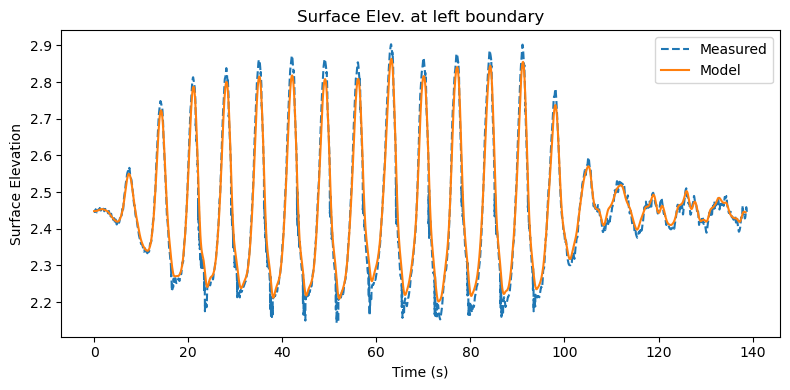

In [12]:
# Plot the data at the prescribed boundary
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)


i = 0
axs[i].plot(lab_time, df_wave_maker["wse"], 
            linestyle = "dashed", label = "Measured")
axs[i].plot(model_time, left_boundary_zs, label = "Model")

# Format the plot
axs[i].legend()
axs[i].set_title("Surface Elev. at left boundary")
axs[i].set_xlabel("Time (s)")
axs[i].set_ylabel("Surface Elevation")

plt.tight_layout()
plt.show()

In [13]:
# Make a function for the bathymatery
# bathy_func now takes in an x - location and outputs the corresponding z location
bathy_func = interp1d(x_grd, zb[0, 0, :])

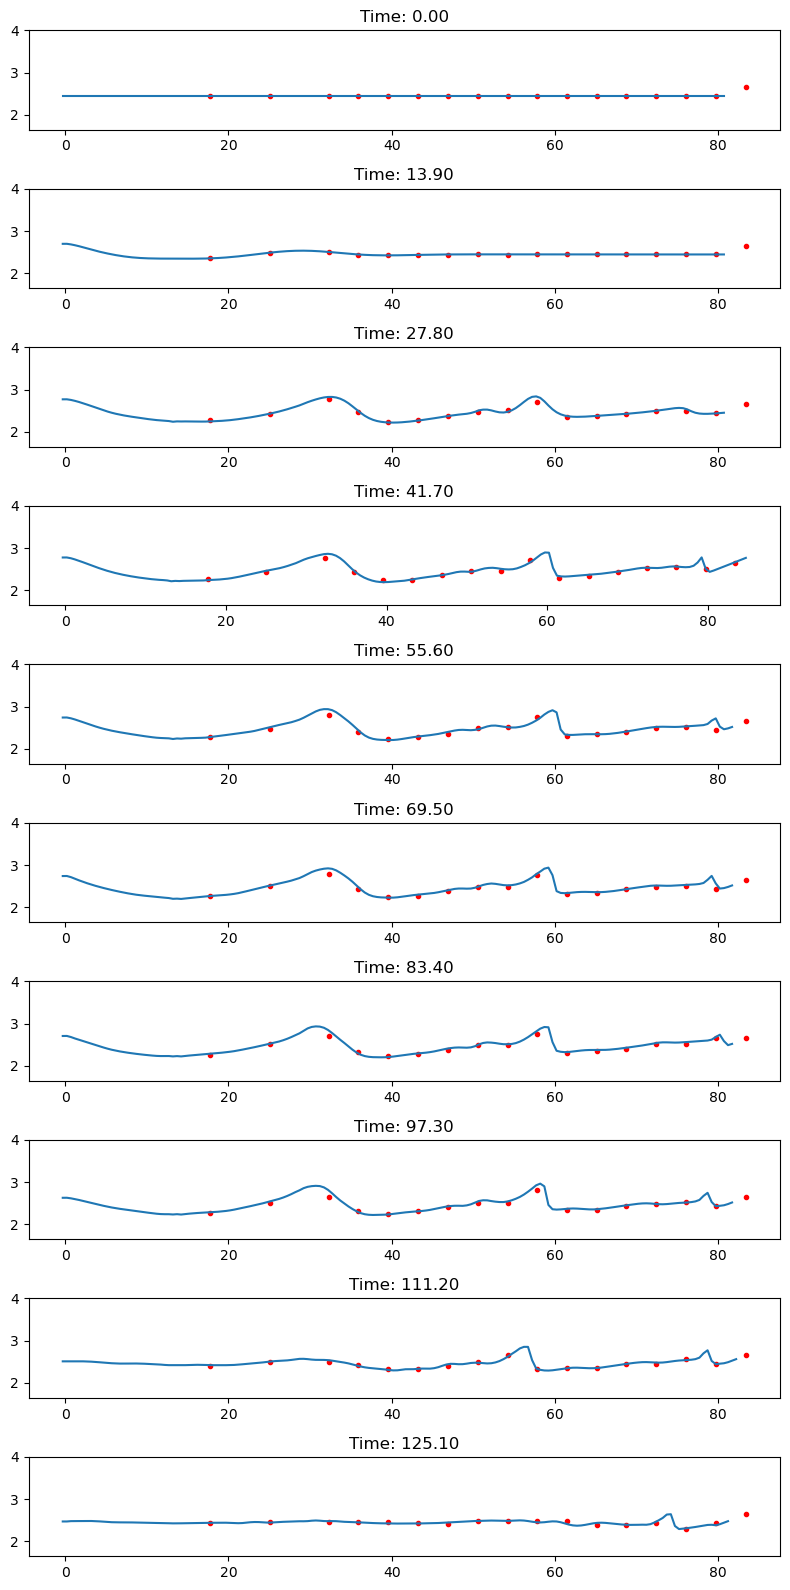

In [14]:
nrows = 10
fig, axs = plt.subplots(nrows = nrows, ncols = 1, figsize = (8,nrows * (1.6)))

# Convert the axs to an array so I can index it, helps if I add more subplots
axs = np.atleast_1d(axs)

# Calc an equal step size to fill the plots
step = math.ceil(len(model_time) / nrows)

# Get the time indices of the model_time arr to plot the data at
time_indices = [val for val in range(0, len(model_time), step)]

# Get the location of the xgrid points
model_xdir = results.var["globalx"][0, :]

# Plot each of surface vs. plots
for i, time_index in enumerate(time_indices):
    # Get the plot time
    model_t = model_time[time_index]

    # Get the closest lab time
    lab_t, lab_index = find_closest(lab_time, model_t)
    # Set the surface elevation at the selected time
    model_zs = results.var["zs"][time_index, 0, :]

    # Plot the surface elevation w/ time
    axs[i].plot(model_xdir, model_zs, label = "Model")

    # Make a copy of the wse elevation from the gauges
    lab_wse_copy = lab_wse.copy()

    # move the wave gauges up by the wse - except for the last one, it's too far too the right
    # for it to measure the d0 water level
    lab_wse_copy[lab_index, :-1] = lab_wse_copy[lab_index, :-1] + zs0

    lab_wse_copy[lab_index, -1] = lab_wse_copy[lab_index, -1] + bathy_func(lab_wg_locs[-1])

    # Plot the measured data
    axs[i].scatter(lab_wg_locs, lab_wse_copy[lab_index, :], 
                label = "lab data {:.2f}".format(lab_t),
                marker = ".", color = "red")
    
    # Plot the bathymtry
    
    # Selecting if only the waves should be plotted
    if False:
        axs[i].plot(model_xdir, zb[time_index, 0, :], label = "bathy")
    else:
        # Select only the waves
        axs[i].set_ylim(zs0-0.8, 4)

    # Setting the legend
    if False:
        axs[i].legend()
    if True:
        axs[i].set_title("Time: {:.2f}".format(model_t))

    # Setting x and y labels - get's kind of messy when there are lots of plots
    if False:
        # Format the plot
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Surface elevation (m)")

plt.tight_layout()
plt.show()
# Compare it against the lab data

In [15]:
# Select the last wg that should be used, using len() gives all of the gauges
end = len(lab_wg_locs)

# Don't include the last one for the time being since it has to account for run-up,
# which I'm not really accounting for at this time
selected_wg_locs = lab_wg_locs[:end]

# Init array to store the RMSE at each time
wse_RMSE = np.zeros(len(model_time))

# Loop over the model times
for i, time in enumerate(model_time):
    # print("Time", time)
    model_zs = results.var["zs"][i, 0, :].copy()

    # Get the x-grid where the xbeach didn't put an output
    x_grd_masked = x_grd[model_zs.mask==True]

    # Get the bathymetry locations where the x_grd is masked
    bathy_x_grd = bathy_func(np.ma.getdata(x_grd_masked))

    # Set all the masked values to the location of the bathymetry
    model_zs[model_zs.mask == True] = bathy_x_grd

    # unmaked_model_xdir = model_xdir[model_zs.mask == False]
    # Make a function that calculates the xbeach surface elevation given the location
    model_zs_func = interp1d(x_grd, np.ma.getdata(model_zs))

    # Interpolate that function onto the location of the sensors
    interp_model_zs = model_zs_func(selected_wg_locs)
    # _, interp_model_zs = find
    # Find the closest time in the lab dataset
    # Lab data set is collected at a much higher temporal resolution
    _, lab_index = find_closest(lab_time, time)

    # Make a copy of the wse elevation from the gauges
    lab_wse_copy = lab_wse[lab_index, :].copy()

    # print("len lab", len(lab_wse_copy))
    # print("len interp model", len(interp_model_zs))
    # move the wave gauges up by the wse - except for the last one, it's too far too the right
    # for it to measure the d0 water level
    lab_wse_copy[:-1] = lab_wse_copy[:-1] + zs0

    lab_wse_copy[-1] = lab_wse_copy[-1] + bathy_func(lab_wg_locs[-1])

    # Calc the RMSE for that time step
    error = calc_RMSE(lab_wse_copy[:end], interp_model_zs)
    # print(error)

    wse_RMSE[i] = error

    # Using an arbitary tolerance to check time steps that have a high error
    if error > 0.2:
        print(i)
        print(time)
        plt.plot(lab_wse_copy, label = "lab")
        plt.plot(interp_model_zs, label = "model", color ="red")
        # plt.plot(model_xdir, model_zs, label = "full data")
        print(model_zs)
        plt.legend()
        plt.show()
        print("error", error)
        # Store the calculate RMSE


Text(0.5, 1.0, 'Water surface elevation RMSE vs. Model time')

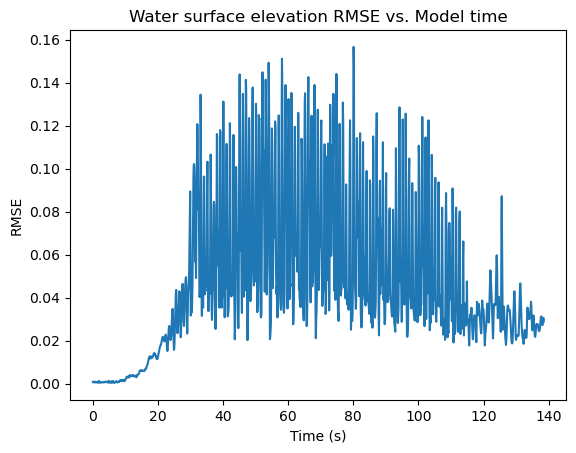

In [16]:
plt.plot(model_time, wse_RMSE)
plt.xlabel("Time (s)")
plt.ylabel("RMSE")
plt.title("Water surface elevation RMSE vs. Model time")

In [17]:
mean_wse_RMSE = wse_RMSE.mean()

print(f"Mean water surface elev. RMSE: {mean_wse_RMSE:.2%}")

Mean water surface elev. RMSE: 4.68%


In [18]:
# Need to calc the RMSE at each of the gauges
